In [1]:
import copick
import keras.src.losses
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers
from matplotlib import patches
import numpy as np
from numba import njit, prange
from scipy.spatial import cKDTree
from collections import defaultdict
from tqdm import tqdm
import tensorflow as tf

In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [4]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks


In [5]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')


In [6]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_6_6', 'TS_86_3', 'TS_73_6', 'TS_99_9']


In [7]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 7
Number of test tomograms: 3


In [8]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


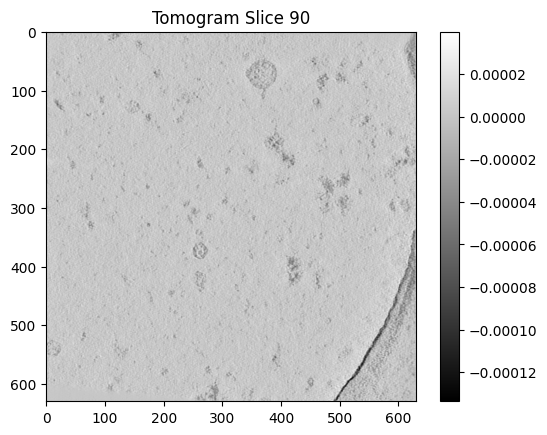

In [9]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [10]:
# Create DataFrame with particle locations
rows = []
for run in training_run_names:
    try:
        label_data = get_label_locations(run, copick_root_train)
        for particle, locations in label_data.items():
            matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if
                                  obj.name == particle]
            if not matching_particles:
                print(f"No matching particle found for {particle} in run {run}")
                continue
            radius = matching_particles[0] / 10
            for location in locations:
                rows.append({
                    'run': run,
                    'particle': particle,
                    'x': location[0],
                    'y': location[1],
                    'z': location[2],
                    'radius': radius
                })
    except Exception as e:
        print(f"Error processing labels for run {run}: {e}")

particle_locations_df = pd.DataFrame(rows)
print(particle_locations_df.sample(5))
print(f"Total labeled particles: {len(particle_locations_df)}")

         run             particle         x         y         z  radius
51    TS_5_4   beta-galactosidase   45.5241  283.8414   62.3402     9.0
551   TS_6_6         apo-ferritin  123.4692  299.4751   92.0469     6.0
947  TS_86_3         beta-amylase  438.4167   44.5833  111.9167     6.5
300   TS_6_4             ribosome  127.3648  438.6703   63.1656    15.0
895  TS_86_3  virus-like-particle  567.0599  386.1008   45.4412    13.5
Total labeled particles: 1269


In [11]:
# Find unique particle types and their radii
unique_particles = particle_locations_df[['particle', 'radius']].drop_duplicates()

particle_types = sorted(particle_locations_df['particle'].unique())
particle_sizes = {}
for i in unique_particles.to_dict(orient='records'):
    particle_sizes[i['particle']] = i['radius']

# Print the unique particle types and their radii
print("Unique Particle Types and Their Radii:")
print(unique_particles.sort_values(by='radius', ascending=False).reset_index(drop=True))

Unique Particle Types and Their Radii:
              particle  radius
0             ribosome    15.0
1  virus-like-particle    13.5
2        thyroglobulin    13.0
3   beta-galactosidase     9.0
4         beta-amylase     6.5
5         apo-ferritin     6.0


In [12]:
def compute_ground_truth_boxes(df):
    """
    Computes ground truth bounding boxes from particle center points and radii.

    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].

    Returns:
        np.ndarray: Array of ground truth boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        np.ndarray: Array of corresponding particle labels (strings).
    """
    # Compute the min and max bounds for each box
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    
    # Combine min and max bounds into a single array
    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    
   
    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx:label for label,idx in label_to_id.items()}
    
    # Encode particle labels as integers
    encoded_labels = df['particle'].map(label_to_id).values
    
    return ground_truth_boxes, encoded_labels, label_to_id,id_to_label

ground_truth_boxes,ground_truth_labels,label_to_id,id_to_label = compute_ground_truth_boxes(particle_locations_df)

print(f'Number of ground truth boxes: {len(ground_truth_boxes)}')

gt_sizes = ground_truth_boxes[:,4]-ground_truth_boxes[:,1]
unique_gt_sizes = np.unique(gt_sizes)
print('Unique ground truth box radii:')
print(np.unique([round(i,4)/2 for i in unique_gt_sizes]))
print('Unique ground truth box diameters:')
print(np.unique([round(i,4) for i in unique_gt_sizes]))

Number of ground truth boxes: 1269
Unique ground truth box radii:
[ 6.   6.5  9.  13.  13.5 15. ]
Unique ground truth box diameters:
[12. 13. 18. 26. 27. 30.]


In [13]:
# Prepare tomogram for model input
print(f"Tomogram shape: {tomograms_train[0]['tomogram'].shape}")
tomogram_with_channel = np.expand_dims(tomograms_train[0]['tomogram'], axis=-1)  # Add channel dimension
print(f'Tomogram With Channel Shape: {tomogram_with_channel.shape}')

Tomogram shape: (184, 630, 630)
Tomogram With Channel Shape: (184, 630, 630, 1)


In [14]:
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Backbone
    x = layers.Conv3D(32,(3,3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    x = layers.Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    
    model = keras.Model(inputs=inputs, outputs=x,name='backbone')

    return model

def calculate_cumulative_stride(backbone_model):
    """
    Calculates the cumulative stride of the backbone CNN by traversing its layers.
    
    Args:
        backbone_model (keras.Model): The backbone CNN model.
    
    Returns:
        tuple: Cumulative strides along (z, y, x).
    """
    stride_z, stride_y, stride_x = 1, 1, 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            pool_size = layer.pool_size  # e.g., (2, 2, 2)
            strides = layer.strides      # e.g., (2, 2, 2)
            stride_z *= strides[0]
            stride_y *= strides[1]
            stride_x *= strides[2]
    return stride_z, stride_y, stride_x

backbone = build_backbone(tomogram_with_channel.shape)
feature_map = backbone.output
print(f'Input Tomogram Shape: {tomogram_with_channel.shape}')
print(f'Feature Map Shape: {feature_map.shape}')

# Calculate 
stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative Strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

scales=sorted(np.array(list(particle_sizes.values()))/stride_z*2)
print(f'Anchor box generation scales: {[str(i) for i in scales]}')

aspect_ratios = [(1, 1, 1)]
print(f'Anchor box generation aspect ratios: {aspect_ratios}')
boxes_per_anchors = len(scales) * len(aspect_ratios)

Input Tomogram Shape: (184, 630, 630, 1)
Feature Map Shape: (None, 46, 158, 158, 64)
Cumulative Strides - Z: 4, Y: 4, X: 4
Anchor box generation scales: ['3.0', '3.25', '4.5', '6.5', '6.75', '7.5']
Anchor box generation aspect ratios: [(1, 1, 1)]


In [15]:
def create_anchors(feature_map_shape, scales, aspect_ratios):
    """
    Generates and clips anchor boxes based on the feature map and anchor parameters.

    Args:
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        voxel_spacing (float): Voxel spacing used in the tomogram.
        scales (list): List of scales.
        aspect_ratios (list of tuples): List of aspect ratios (w, h, d).

    Returns:
        np.ndarray: Array of clipped anchor boxes with shape (N, 6).
    """
    D, H, W = feature_map_shape[1], feature_map_shape[2], feature_map_shape[3]
    # Define centers based on voxel spacing and feature map stride
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes

def clip_boxes(anchor_boxes, input_shape):
    """
    Clips anchor boxes to lie within the input volume.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        input_shape (tuple): Shape of the input volume (D, H, W, C).

    Returns:
        np.ndarray: Clipped anchor boxes.
    """
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    # Clipping
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)  # x_min
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)  # y_min
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)  # z_min
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)  # x_max
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)  # y_max
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)  # z_max
    return anchor_boxes

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios, stride=4):
    """
    Efficiently generates anchor boxes using numpy broadcasting with correct shape alignment.
    
    Args:
        centers_z (np.ndarray): Array of center z-coordinates, shape (Nz,)
        centers_y (np.ndarray): Array of center y-coordinates, shape (Ny,)
        centers_x (np.ndarray): Array of center x-coordinates, shape (Nx,)
        scales (list): List of scales, length S
        aspect_ratios (list of tuples): List of aspect ratios (w_ratio, h_ratio, d_ratio), length R
        stride (int): Stride factor between input and feature map
    
    Returns:
        np.ndarray: Array of anchor boxes with shape (Nz * Ny * Nx * S * R, 6), 
                    where each box is (x_min, y_min, z_min, x_max, y_max, z_max)
    """
    # Convert scales and aspect_ratios to NumPy arrays
    scales = np.array(scales)  # Shape: (S,)
    aspect_ratios = np.array(aspect_ratios)  # Shape: (R, 3)
    
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    num_sizes = num_scales * num_ratios
    
    # Compute all (w, h, d) combinations
    # Repeat each scale for each aspect ratio
    scales_repeated = np.repeat(scales, num_ratios)  # Shape: (S*R,)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))  # Shape: (S*R, 3)
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled  # Shape: (S*R, 3)
    
    # Generate all combinations of center coordinates
    # Using meshgrid with 'ij' indexing to match the nested loop order: z, y, x
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')  # Each of shape (Nz, Ny, Nx)
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)  # Shape: (Nz*Ny*Nx, 3)
    
    # Scale centers back to input space
    # centers = centers * stride  # Assuming each feature map voxel corresponds to 'stride' in input#
    
    # Number of centers and sizes
    N = centers.shape[0]  # Nz * Ny * Nx
    M = sizes.shape[0]    # S * R
    
    # Expand dimensions to enable broadcasting
    # centers_expanded: (N, 1, 3)
    # sizes_expanded: (1, M, 3)
    centers_expanded = centers[:, np.newaxis, :]  # Shape: (N, 1, 3)
    sizes_expanded = sizes[np.newaxis, :, :]      # Shape: (1, M, 3)
    
    # Compute min and max coordinates
    mins = centers_expanded - sizes_expanded / 2.0  # Shape: (N, M, 3)
    maxs = centers_expanded + sizes_expanded / 2.0  # Shape: (N, M, 3)
    
    # Stack to get (x_min, y_min, z_min, x_max, y_max, z_max)
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)  # Shape: (N*M, 6)
    
    return anchor_boxes

# Generate anchor boxes based on the feature map
anchor_boxes = create_anchors(feature_map.shape, scales, aspect_ratios)
print(f"Generated {anchor_boxes.shape[0]} anchor boxes.")

print('Unique anchor box diameters (feature map space):')
print(np.unique(anchor_boxes[:,4]-anchor_boxes[:,1]))
print('Unique anchor box diameters (original image space):')
print(np.unique(anchor_boxes[:,4]-anchor_boxes[:,1])*stride_z)

Generated 6890064 anchor boxes.
Unique anchor box diameters (feature map space):
[1.5   1.625 2.25  2.5   2.625 3.    3.25  3.375 3.75  4.25  4.375 4.5
 4.75  5.25  5.375 5.75  6.25  6.375 6.5   6.75  7.5  ]
Unique anchor box diameters (original image space):
[ 6.   6.5  9.  10.  10.5 12.  13.  13.5 15.  17.  17.5 18.  19.  21.
 21.5 23.  25.  25.5 26.  27.  30. ]


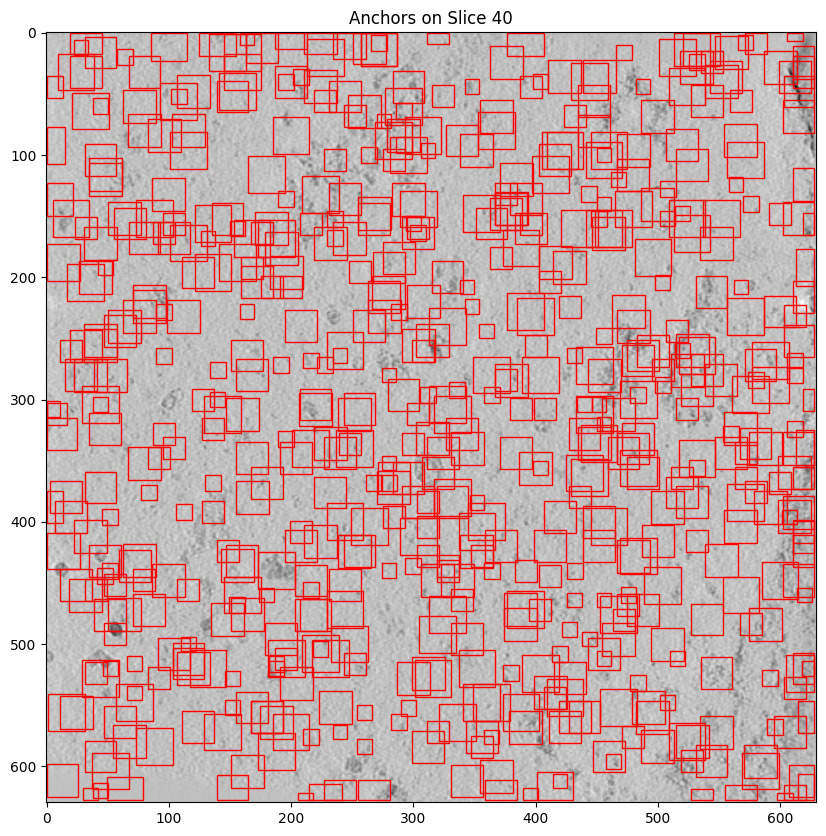

In [16]:
def visualize_anchors(tomogram, anchor_boxes, slice_index,strides, max_anchors=100):
    """
    Visualizes a subset of anchor boxes on a specific slice of the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        slice_index (int): Index of the slice to visualize.
        max_anchors (int): Maximum number of anchors to visualize.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    count = 0
    
    num_boxes = anchor_boxes.shape[0]
    indices = np.random.choice(num_boxes, size=max_anchors, replace=False)
    random_anchors=anchor_boxes[indices]
    
    for anchor in random_anchors:
        
        # Convert anchor box to image space
        x_min = anchor[0] * strides[0]
        y_min = anchor[1] * strides[1]
        z_min = anchor[2] * strides[2]
        x_max = anchor[3] * strides[0]
        y_max = anchor[4] * strides[1]
        z_max = anchor[5] * strides[2]
        
        if z_min <= slice_index < z_max:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show() 
    
# Visualize a subset of anchors on a specific slice
slice_index = 40
strides=stride_z,stride_y,stride_x
visualize_anchors(tomograms_train[0]['tomogram'], anchor_boxes, slice_index, strides, max_anchors=5000)


In [17]:
@njit
def floor_div(a, b):
    return np.floor(a / b).astype(np.int32)

def get_grid_indices(boxes, grid_min, grid_cell_size, grid_size):
    """
    Compute the grid cell indices (min and max) for each box.

    Args:
        boxes (np.ndarray): Array of boxes, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        tuple: min_indices (N,3), max_indices (N,3)
    """
    min_indices = floor_div(boxes[:, :3] - grid_min, np.array(grid_cell_size))
    max_indices = floor_div(boxes[:, 3:6] - grid_min, np.array(grid_cell_size))
    
    # Clamp indices to be within [0, grid_size - 1]
    min_indices = np.maximum(min_indices, 0)
    max_indices = np.minimum(max_indices, np.array(grid_size) - 1)
    
    return min_indices, max_indices

def assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size):
    """
    Assign GT boxes to grid cells.

    Args:
        ground_truth_boxes_fm (np.ndarray): GT boxes in feature map space, shape (M, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        dict: Mapping from grid cell ID to list of GT box indices
    """
    M = ground_truth_boxes_fm.shape[0]
    gt_min_idx, gt_max_idx = get_grid_indices(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)  # (M,3), (M,3)
    
    grid_dict = defaultdict(list)
    
    for gt_idx in range(M):
        x_min, y_min, z_min = gt_min_idx[gt_idx]
        x_max, y_max, z_max = gt_max_idx[gt_idx]
        
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                for z in range(z_min, z_max + 1):
                    grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                    grid_dict[grid_id].append(gt_idx)
    
    return grid_dict

def retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000):
    """
    Retrieve relevant GT boxes for each anchor based on grid cell overlap.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)
        grid_dict (dict): Mapping from grid cell ID to list of GT box indices
        batch_size (int): Number of anchors to process in each batch

    Returns:
        list of lists: Each sublist contains GT box indices relevant to the anchor
    """
    N = anchor_boxes.shape[0]
    print('Getting grid index for each anchor box')
    anchor_min_idx, anchor_max_idx = get_grid_indices(anchor_boxes, grid_min, grid_cell_size, grid_size)  # (N,3), (N,3)
    
    relevant_gt_per_anchor = [[] for _ in range(N)]
    
    print('Finding relevant ground truth boxes for each anchor')
    for start in tqdm(range(0, N, batch_size)):
        end = min(start + batch_size, N)
        batch_min = anchor_min_idx[start:end]  # (B,3)
        batch_max = anchor_max_idx[start:end]  # (B,3)
        
        for i in range(end - start):
            anchor_idx = start + i
            x_min, y_min, z_min = batch_min[i]
            x_max, y_max, z_max = batch_max[i]
            
            grid_ids = []
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    for z in range(z_min, z_max + 1):
                        grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                        grid_ids.append(grid_id)
            
            gt_indices = []
            for grid_id in grid_ids:
                if grid_id in grid_dict:
                    gt_indices.extend(grid_dict[grid_id])
            
            # Remove duplicates
            gt_indices = list(set(gt_indices))
            relevant_gt_per_anchor[anchor_idx] = gt_indices
    
    return relevant_gt_per_anchor

def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D boxes using float32 for efficiency.

    Args:
        boxes1 (np.ndarray): Shape (N, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].
        boxes2 (np.ndarray): Shape (M, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].

    Returns:
        np.ndarray: IoU array of shape (N,)
    """
    # Compute intersection coordinates
    x_min = np.maximum(boxes1[:, 0], boxes2[:, 0])
    y_min = np.maximum(boxes1[:, 1], boxes2[:, 1])
    z_min = np.maximum(boxes1[:, 2], boxes2[:, 2])
    x_max = np.minimum(boxes1[:, 3], boxes2[:, 3])
    y_max = np.minimum(boxes1[:, 4], boxes2[:, 4])
    z_max = np.minimum(boxes1[:, 5], boxes2[:, 5])

    # Compute intersection dimensions
    inter_w = np.maximum(0, x_max - x_min)
    inter_h = np.maximum(0, y_max - y_min)
    inter_d = np.maximum(0, z_max - z_min)
    intersection = inter_w * inter_h * inter_d  # (N,)

    # Compute volumes
    volume1 = (boxes1[:, 3] - boxes1[:, 0]) * \
              (boxes1[:, 4] - boxes1[:, 1]) * \
              (boxes1[:, 5] - boxes1[:, 2])  # (N,)
    volume2 = (boxes2[:, 3] - boxes2[:, 0]) * \
              (boxes2[:, 4] - boxes2[:, 1]) * \
              (boxes2[:, 5] - boxes2[:, 2])  # (M,)

    # Compute union volume
    union = volume1 + volume2 - intersection  # (N,)

    # Compute IoU
    iou = intersection / np.maximum(union, 1e-6)  # Avoid division by zero

    return iou.astype(np.float32)  # Ensure float32

@njit(parallel=True)
def compute_deltas_batch_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
                    stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def match_anchors_optimized(
    anchor_boxes, 
    ground_truth_boxes_fm, 
    ground_truth_labels, 
    stride=(4,4,4), 
    iou_thresholds=(0.3, 0.7), 
    grid_cell_size=(10.0, 10.0, 10.0)
):
    """
    Optimized matching of anchors to ground truth boxes using grid-based spatial partitioning.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes in feature map space with shape (N, 6).
        ground_truth_boxes_fm (np.ndarray): Array of ground truth boxes in feature map space with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        stride (tuple): Stride factors along (z, y, x).
        iou_thresholds (tuple): Tuple of (low_threshold, high_threshold) for negative and positive IoU.
        grid_cell_size (tuple): Size of each grid cell along (x, y, z).

    Returns:
        tuple: (anchor_labels, anchor_deltas, best_gt_idx)
            - anchor_labels (np.ndarray): Labels for each anchor (-1: ignored, -2: background, >0: class labels).
            - anchor_deltas (np.ndarray): Deltas (dx, dy, dz, dw, dh, dd) for each positive anchor.
            - best_gt_idx (np.ndarray): Indices of the best ground truth box for each anchor.
    """
    low_threshold, high_threshold = iou_thresholds
    N = anchor_boxes.shape[0]
    M = ground_truth_boxes_fm.shape[0]
    
    # Initialize labels and deltas
    anchor_labels = np.full(N, -1, dtype=np.int32)      # -1: ignore
    anchor_deltas = np.zeros((N, 6), dtype=np.float32)  # Deltas for positive anchors
    best_gt_idx = np.full(N, -1, dtype=np.int32)       # Best GT index for each anchor
    
    # Compute grid boundaries
    print('Computing grid boundaries')
    all_boxes = np.vstack((anchor_boxes, ground_truth_boxes_fm))
    grid_min = all_boxes[:, :3].min(axis=0)  # (x_min, y_min, z_min)
    grid_max = all_boxes[:, 3:6].max(axis=0)  # (x_max, y_max, z_max)
    
    # Compute grid size
    grid_size = np.ceil((grid_max - grid_min) / grid_cell_size).astype(int)
    grid_size = tuple(grid_size)  # (x_cells, y_cells, z_cells)
    
    print(f'Grid size: {grid_size}')
    
    # Assign GT boxes to grid cells
    print('Assigning GT boxes to grid cells')
    grid_dict = assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)
    
    # Retrieve relevant GT boxes for each anchor
    print('Retrieving relevant GT boxes for each anchor')
    relevant_gt_per_anchor = retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000)
    
    # Compute deltas requires stride information applied appropriately
    stride_array = np.array([
        stride[2], stride[1], stride[0],  # x, y, z for min coords
        stride[2], stride[1], stride[0]   # x, y, z for max coords
    ], dtype=np.float32)
    
    # Iterate over each anchor to assign labels and compute deltas
    print('Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels')
    for anchor_idx in tqdm(range(N)):
        gt_indices = relevant_gt_per_anchor[anchor_idx]
        if len(gt_indices) == 0:
            # No overlapping GT boxes, assign as background
            anchor_labels[anchor_idx] = -2
            continue
        
        # Extract the anchor and relevant GT boxes
        anchor_box = anchor_boxes[anchor_idx].astype(np.float32).reshape(1,6)
        gt_boxes = ground_truth_boxes_fm[gt_indices].astype(np.float32)  # (k,6)
        
        # Compute IoUs
        ious = compute_iou_3d(anchor_box, gt_boxes)  # (k,)
        
        # Find the GT box with the maximum IoU
        max_iou_idx = np.argmax(ious)
        max_iou = ious[max_iou_idx]
        best_gt = gt_indices[max_iou_idx]
        
        if max_iou >= high_threshold:
            anchor_labels[anchor_idx] = ground_truth_labels[best_gt]
            # Compute deltas
            deltas = compute_iou_deltas(anchor_box, ground_truth_boxes_fm[best_gt].reshape(1,6), stride_array)
            anchor_deltas[anchor_idx] = deltas[0]
            best_gt_idx[anchor_idx] = best_gt
        elif max_iou < low_threshold:
            anchor_labels[anchor_idx] = -2  # Background
        else:
            anchor_labels[anchor_idx] = -1  # Ignore
    
    print('Anchor matching completed.')
    return anchor_labels, anchor_deltas, best_gt_idx

@njit(parallel=True)
def compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def compute_iou_deltas(anchor_boxes, gt_boxes, stride_array):
    """
    Wrapper function to compute deltas using Numba-accelerated function.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in feature map space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)

    Returns:
        np.ndarray: Deltas (K, 6)
    """
    K = anchor_boxes.shape[0]
    deltas = np.zeros((K, 6), dtype=np.float32)
    compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas)
    return deltas

grid_cell_size=(5.0, 5.0, 5.0)
stride = (stride_z, stride_y, stride_x)

# Project ground truth boxes to feature map space
print('Calculating ground truth boxes in feature map space.')
stride_array = np.array([
    stride[2], stride[1], stride[0],  # x, y, z for min coords
    stride[2], stride[1], stride[0]   # x, y, z for max coords
])
ground_truth_boxes_fm = ground_truth_boxes / stride_array.reshape(1,6)  # (M,6)

# Perform optimized matching
anchor_labels, anchor_deltas, best_gt_idx = match_anchors_optimized(
    anchor_boxes=anchor_boxes,
    ground_truth_boxes_fm=ground_truth_boxes_fm,
    ground_truth_labels=ground_truth_labels,
    stride=stride,
    iou_thresholds=(0.3,0.6),
    grid_cell_size=grid_cell_size
)

# Verify the number of positive matches
num_positive = np.sum(anchor_labels > -1)
num_background = np.sum(anchor_labels == -2)
num_ignored = np.sum(anchor_labels == -1)
print(f"Number of positive anchors: {num_positive}")
print(f"Number of background anchors: {num_background}")
print(f"Number of ignored anchors: {num_ignored}")

Calculating ground truth boxes in feature map space.
Computing grid boundaries
Grid size: (np.int64(33), np.int64(33), np.int64(10))
Assigning GT boxes to grid cells
Retrieving relevant GT boxes for each anchor
Getting grid index for each anchor box
Finding relevant ground truth boxes for each anchor


100%|██████████| 690/690 [00:29<00:00, 23.52it/s]


Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels


100%|██████████| 6890064/6890064 [01:38<00:00, 70029.88it/s] 


Anchor matching completed.
Number of positive anchors: 14343
Number of background anchors: 6645135
Number of ignored anchors: 230586


In [18]:
print(f'{len(np.unique(best_gt_idx))-1}/{len(ground_truth_boxes_fm)} particles assigned at least one anchor box')

print('Number of each particle type assigned at least one anchor box:')
holder={}
for i,v in zip(anchor_labels,best_gt_idx):
    if i>-1:
        holder[int(v)]=id_to_label[int(i)]
for particle in particle_types:
    print(f'{particle}: {len([i for i,v in holder.items() if v==particle])}/{len([i for i in ground_truth_labels if i == label_to_id[particle]])}')

1102/1269 particles assigned at least one anchor box
Number of each particle type assigned at least one anchor box:
apo-ferritin: 238/375
beta-amylase: 62/87
beta-galactosidase: 109/112
ribosome: 331/331
thyroglobulin: 251/251
virus-like-particle: 111/113


In [19]:
def subdivide_tomogram(tomogram, sub_volume_size,sub_volume_stride):
    """
    Subdivide a 3D tomogram into smaller subvolumes.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        stride (tuple): Stride for moving the window (D, H, W).

    Returns:
        list of np.ndarray: List of subvolumes.
    """
    D, H, W = tomogram.shape
    sub_D, sub_H, sub_W = sub_volume_size
    stride_D, stride_H, stride_W = sub_volume_stride

    subvolumes = []
    for z in range(0, D - sub_D + 1, stride_D):
        for y in range(0, H - sub_H + 1, stride_H):
            for x in range(0, W - sub_W + 1, stride_W):
                sub = tomogram[z:z+sub_D, y:y+sub_H, x:x+sub_W]
                subvolumes.append(sub)
    return subvolumes

# Example usage:
sub_volume_size = (100, 200, 200)
sub_volume_stride = (20,20,20)

tomograms_sub_train = []
for tomo in tomograms_train:
    subvolumes = subdivide_tomogram(tomo['tomogram'], sub_volume_size,sub_volume_stride)
    tomograms_sub_train.extend([{'run': tomo['run'], 'tomogram': sub} for sub in subvolumes])

print(f"Number of training subvolumes: {len(tomograms_sub_train)}")


Number of training subvolumes: 16940


In [20]:
def get_subvolume_ground_truth(df, sub_volume_origin, sub_volume_size, stride=1):
    """
    Extract ground truth boxes within a subvolume.

    Args:
        df (pd.DataFrame): DataFrame with particle locations and labels.
        sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
        sub_volume_size (tuple): (W, H, D) size of the subvolume.
        stride (int): Stride factor for normalization if needed.

    Returns:
        pd.DataFrame: Ground truth boxes within the subvolume.
    """
    x_start, y_start, z_start = sub_volume_origin
    W, H, D = sub_volume_size

    # Define the bounds of the subvolume
    x_end = x_start + W
    y_end = y_start + H
    z_end = z_start + D

    # Filter particles within the subvolume
    mask = (
        (df['x'] >= x_start) & (df['x'] < x_end) &
        (df['y'] >= y_start) & (df['y'] < y_end) &
        (df['z'] >= z_start) & (df['z'] < z_end)
    )
    sub_gt = df[mask].copy()

    # Adjust coordinates relative to the subvolume origin
    sub_gt['x'] -= x_start
    sub_gt['y'] -= y_start
    sub_gt['z'] -= z_start

    return sub_gt

# Example integration with subvolumes
for sub in tqdm(tomograms_sub_train):
    origin = (0, 0, 0)  # Adjust based on how you store subvolume positions
    sub_gt = get_subvolume_ground_truth(particle_locations_df, origin, sub_volume_size)
    sub['ground_truth'] = sub_gt


100%|██████████| 16940/16940 [00:06<00:00, 2500.43it/s]


In [22]:
# rpn = build_rpn(feature_map,len(particle_types),number_of_anchors)
# model = keras.Model(inputs=backbone.input, outputs=rpn)
# model.summary()

In [ ]:
import tensorflow as tf
from keras import layers, Model
import numpy as np

def build_rpn(feature_map,particles_count,number_of_anchors):
    # Shared convolutional layer
    shared = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(feature_map)
    
    # Objectness score branchb
    objectness = layers.Conv3D(number_of_anchors * particles_count, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    
    # Bounding box regression branch
    bbox_regression = layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_regression')(shared)
    
    return objectness, bbox_regression

# Placeholder for RoI Align Layer
class RoIAlign3D(layers.Layer):
    def __init__(self, pooled_size=(7, 7, 7), sampling_ratio=2, **kwargs):
        super(RoIAlign3D, self).__init__(**kwargs)
        self.pooled_size = pooled_size
        self.sampling_ratio = sampling_ratio

    def call(self, feature_map, rois):
        # Placeholder: Replace this with actual RoI Align logic
        batch_size = tf.shape(feature_map)[0]
        num_rois = tf.shape(rois)[1]
        pooled_depth, pooled_height, pooled_width = self.pooled_size
        num_channels = feature_map.shape[-1]

        # Return a dummy tensor for now
        return tf.zeros((batch_size, num_rois, pooled_depth, pooled_height, pooled_width, num_channels))

# Detection Head
def build_detection_head(roi_features, num_classes):
    x = layers.Flatten()(roi_features)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)

    class_logits = layers.Dense(num_classes, activation='softmax', name='class_logits')(x)
    bbox_deltas = layers.Dense(6 * num_classes, activation='linear', name='bbox_deltas')(x)

    return class_logits, bbox_deltas

class EmbeddedLayer(keras.layers.Layer):
    def __init__(self, 
                 iou_threshold=0.7, 
                 max_proposals=2000, 
                 **kwargs):
        super(EmbeddedLayer, self).__init__(**kwargs)
        self.iou_threshold = iou_threshold
        self.max_proposals = max_proposals

    def call(self, inputs):
        """
        Args:
            inputs: A list containing [objectness, bbox_deltas, anchor_boxes]
                - objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
                - bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
                - anchor_boxes: Tensor of shape (total_anchors, 6)
        
        Returns:
            proposals: Tensor of shape (batch_size, max_proposals, 6)
        """
        objectness, bbox_deltas, anchor_boxes = inputs
        return self.generate_proposals(objectness, bbox_deltas, anchor_boxes)

    def generate_proposals(self, objectness, bbox_deltas, anchor_boxes):
        """
        Generates region proposals based on RPN output using tf.map_fn.

        Args:
            objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
            bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
            anchor_boxes: Tensor of shape (total_anchors, 6)

        Returns:
            proposals: Tensor of shape (batch_size, max_proposals, 6)
        """
        # Reshape objectness and bbox_deltas to (batch_size, total_anchors)
        batch_size = tf.shape(objectness)[0]
        total_anchors = tf.shape(anchor_boxes)[0]

        objectness = tf.reshape(objectness, (batch_size, total_anchors))  # (batch_size, total_anchors)
        bbox_deltas = tf.reshape(bbox_deltas, (batch_size, total_anchors, 6))  # (batch_size, total_anchors, 6)

        # Decode bbox_deltas to get proposed boxes
        proposals = self.decode_deltas(anchor_boxes, bbox_deltas)  # (batch_size, total_anchors, 6)

        # Clip proposals to image boundaries
        # Assuming input_shape is known (D, H, W). You might need to pass it or infer it differently.
        # Here, we'll infer it from the objectness tensor shape (D, H, W)
        input_shape = tf.shape(objectness)[1:4]  # (D, H, W)
        proposals = self.clip_boxes(proposals, input_shape)  # (batch_size, total_anchors, 6)

        # Define a function to apply NMS to each example in the batch
        def nms_per_example(args):
            scores, boxes = args
            selected_indices = tf.image.non_max_suppression(
                boxes=boxes,
                scores=scores,
                max_output_size=self.max_proposals,
                iou_threshold=self.iou_threshold
            )
            selected_boxes = tf.gather(boxes, selected_indices)
            # Pad selected_boxes to max_proposals
            selected_boxes_padded = tf.pad(selected_boxes, 
                                          [[0, self.max_proposals - tf.shape(selected_boxes)[0]], [0, 0]],
                                          constant_values=0)
            selected_boxes_padded = selected_boxes_padded[:self.max_proposals]
            return selected_boxes_padded

        # Apply NMS across the batch using tf.map_fn
        proposals_padded = tf.map_fn(
            nms_per_example, 
            (objectness, proposals), 
            dtype=tf.float32
        )

        return proposals_padded  # (batch_size, max_proposals, 6)

    def decode_deltas(self, anchors, deltas):
        """
        Decodes bounding box deltas into final proposals.

        Args:
            anchors: Tensor of shape (total_anchors, 6)
            deltas: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        # Compute anchor centers and sizes
        x_a = (anchors[:, 0] + anchors[:, 3]) / 2.0
        y_a = (anchors[:, 1] + anchors[:, 4]) / 2.0
        z_a = (anchors[:, 2] + anchors[:, 5]) / 2.0
        w_a = anchors[:, 3] - anchors[:, 0]
        h_a = anchors[:, 4] - anchors[:, 1]
        d_a = anchors[:, 5] - anchors[:, 2]

        # Expand anchors to match batch size
        x_a = tf.expand_dims(x_a, axis=0)  # (1, total_anchors)
        y_a = tf.expand_dims(y_a, axis=0)
        z_a = tf.expand_dims(z_a, axis=0)
        w_a = tf.expand_dims(w_a, axis=0)
        h_a = tf.expand_dims(h_a, axis=0)
        d_a = tf.expand_dims(d_a, axis=0)

        # Split deltas
        dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

        # Compute proposal centers
        x_p = x_a + dx * w_a
        y_p = y_a + dy * h_a
        z_p = z_a + dz * d_a

        # Compute proposal sizes
        w_p = w_a * tf.exp(dw)
        h_p = h_a * tf.exp(dh)
        d_p = d_a * tf.exp(dd)

        # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
        x_min = x_p - w_p / 2.0
        y_min = y_p - h_p / 2.0
        z_min = z_p - d_p / 2.0
        x_max = x_p + w_p / 2.0
        y_max = y_p + h_p / 2.0
        z_max = z_p + d_p / 2.0

        decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        return decoded_boxes  # (batch_size, total_anchors, 6)

    def clip_boxes(self, boxes, input_shape):
        """
        Clips boxes to lie within the image boundaries.

        Args:
            boxes: Tensor of shape (batch_size, total_anchors, 6)
            input_shape: Tensor of shape (3,) representing (D, H, W)

        Returns:
            clipped_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        D, H, W = input_shape[0], input_shape[1], input_shape[2]
        x_min, y_min, z_min, x_max, y_max, z_max = tf.split(boxes, num_or_size_splits=6, axis=-1)

        x_min = tf.clip_by_value(x_min, 0.0, tf.cast(W - 1, tf.float32))
        y_min = tf.clip_by_value(y_min, 0.0, tf.cast(H - 1, tf.float32))
        z_min = tf.clip_by_value(z_min, 0.0, tf.cast(D - 1, tf.float32))
        x_max = tf.clip_by_value(x_max, 0.0, tf.cast(W - 1, tf.float32))
        y_max = tf.clip_by_value(y_max, 0.0, tf.cast(H - 1, tf.float32))
        z_max = tf.clip_by_value(z_max, 0.0, tf.cast(D - 1, tf.float32))

        clipped_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        return clipped_boxes  # (batch_size, total_anchors, 6)

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the layer.

        Args:
            input_shape: List of input shapes [objectness, bbox_deltas, anchor_boxes]

        Returns:
            output_shape: (batch_size, max_proposals, 6)
        """
        batch_size = input_shape[0][0]
        return (batch_size, self.max_proposals, 6)

    def get_config(self):
        config = super(EmbeddedLayer, self).get_config()
        config.update({
            'iou_threshold': self.iou_threshold,
            'max_proposals': self.max_proposals,
        })
        return config



# Build Faster R-CNN Model
def build_faster_rcnn(input_shape, num_classes, anchor_boxes, num_anchors,max_proposals):
    inputs = layers.Input(shape=input_shape)

    print('Creating backbone and feature map')
    # Step 1: Backbone network
    backbone = build_backbone(input_shape)
    feature_map = backbone(inputs)

    print('Building RPN')
    # Step 2: RPN network feature_map
    objectness, bbox_deltas = build_rpn(feature_map, num_classes, num_anchors)
    
    print('Generating proposals from RPN output')
    # Convert anchor_boxes to tensor
    anchor_boxes_tensor = tf.constant(anchor_boxes, dtype=tf.float32)
    
    # Step 3: Generate proposals from RPN output
    # EmbeddedLayer expects [objectness, bbox_deltas, anchor_boxes]
    proposals = EmbeddedLayer(max_proposals=max_proposals)([objectness, bbox_deltas, anchor_boxes_tensor])

    print('Building ROI alignment layer')
    # Step 4: RoI Align
    roi_features = RoIAlign3D(pooled_size=(7, 7, 7), sampling_ratio=2)(feature_map, proposals)

    print('Building detection head')
    # Step 5: Detection head
    class_logits, bbox_deltas_final = build_detection_head(roi_features, num_classes)

    print('Defining final model')
    # Define the final model
    model = Model(inputs=inputs, outputs=[class_logits, bbox_deltas_final], name="faster_rcnn")
    
    return model

print(type(tomogram_with_channel))
max_proposals=2000
faster_rcnn_model = build_faster_rcnn(tomogram_with_channel.shape, len(particle_types), anchor_boxes, boxes_per_anchors,max_proposals)
faster_rcnn_model.summary()


<class 'numpy.ndarray'>
Creating backbone and feature map
Building RPN
Generating proposals from RPN output
Building ROI alignment layer
Building detection head
